# Humpback Whale Identification

In [8]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torchvision import transforms

%matplotlib inline

## Load datasets

#### Unpack images

In [10]:
root_dir = "train"
raw_images_df = pd.read_csv('train.csv')
images = raw_images_df.values.tolist()
for image, label in images:
    dest_dir = os.path.join(root_dir, label)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
        
    os.rename(os.path.join(root_dir, image), os.path.join(dest_dir, image))

#### Prepare transformations

In [85]:
transform = transforms.Compose([
    transforms.Resize((200, 600)),
    transforms.ToTensor()
])

In [86]:
train_dataset = torchvision.datasets.ImageFolder(root=root_dir, 
                                                 transform=transform)

#### Create loaders

In [90]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [91]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

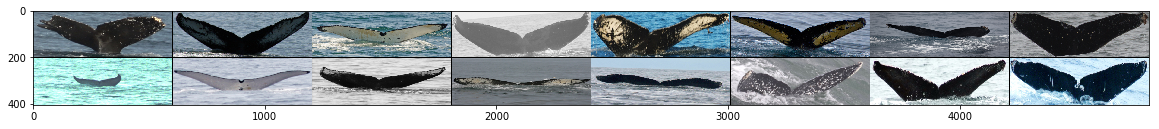

In [96]:
fig, axes = plt.subplots(figsize=(20, 8))

def imshow(x):
#     img = img / 2 + 0.5     # unnormalize
    x = x.numpy()
    x = np.transpose(x, (1, 2, 0))
    plt.imshow(x)
       
imshow(torchvision.utils.make_grid(images))

## Define network

In [97]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.PReLU(),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256, self.n_classes)
        )
        
    def forward(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
class TripletNet(nn.Module):
    def __init__(self, embedding):
        super(TripletNet, self).__init__()
        self.embedding = embedding
    
    def forward(self, x1, x2, x3):
        output1 = self.embedding(x1)
        output2 = self.embedding(x2)
        output3 = self.embedding(x3)
        return output1, output2, output3
    

cnn = CNN(10)
net = TripletNet(cnn)
net

TripletNet(
  (embedding): CNN(
    (cnn): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

## Train network

Prepare triplet loss function, which take embeddings of an anchor sample, a positive and a negative sample.

In [98]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow().sum(1)
        distance_negative = (anchor - negative).pow().sum(1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

Set loss function and optimizer

In [99]:
margin = .1
lr = 1e-3
loss_fn = TripletLoss(margin)
optimizer = optim.Adam(net.parameters())

Define train function

In [ ]:
def prepare_batch(batch):
    pass

def update_model(trainer, batch):
    model.train()
    optimizer.zero_grad()
    inputs, labels = prepare_batch(batch)

## Validate network

## Make predictions 

## Submissions